In [1]:
import torch, random
import torch.nn as nn
import sinabs.layers as sl
from tqdm.notebook import tqdm

from tonic.datasets.dvsgesture import DVSGesture
from tonic.transforms import ToFrame
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from sinabs.activation.surrogate_gradient_fn import PeriodicExponential

import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

## Loading Data

In [3]:
batch_size = 3
num_workers = 1
epochs = 20
lr = 1e-3

In [4]:
root_dir = "./DVSGESTURE"
_ = DVSGesture(save_to=root_dir, train=True)
_ = DVSGesture(save_to=root_dir, train=False)

In [5]:
n_time_steps = 50
to_raster = ToFrame(sensor_size=DVSGesture.sensor_size, n_time_bins=n_time_steps)

snn_train_dataset = DVSGesture(save_to=root_dir, train=True, transform=to_raster)
snn_test_dataset = DVSGesture(save_to=root_dir, train=False, transform=to_raster)

In [6]:
sample_data, label = snn_train_dataset[0]
print(f"The transformed array is in shape [Time-Step, Channel, Height, Width] --> {sample_data.shape}")

The transformed array is in shape [Time-Step, Channel, Height, Width] --> (50, 2, 128, 128)


In [7]:
snn_train_dataloader = DataLoader(snn_train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

## Network Module

We need to define a `nn.Module` implementing the network we want the chip to reproduce.

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA RTX A4000


In [9]:
class SNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(2, 10, 2, 1, bias=False)
        self.iaf1 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())
        self.pool1 = nn.AvgPool2d(2,2)
        self.pool1a = nn.AvgPool2d(6,6)

        self.conv2 = nn.Conv2d(10, 10, 2, 1, bias=False)
        self.iaf2 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())
        self.pool2 = nn.AvgPool2d(3,3)

        self.conv3 = nn.Conv2d(10, 10, 3, 1, bias=False)
        self.iaf3 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())
        self.pool3 = nn.AvgPool2d(2,2)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(810, 100, bias=False)
        self.iaf4 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())

        self.fc2 = nn.Linear(100, 100, bias=False)
        self.iaf5 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())

        self.fc3 = nn.Linear(100, 100, bias=False)
        self.iaf6 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())

        self.fc4 = nn.Linear(100, 11, bias=False)
        self.iaf7 = sl.IAFSqueeze(batch_size=batch_size, min_v_mem=-1.0, surrogate_grad_fn=PeriodicExponential())

        self.merge_fc = sl.Merge()
        self.merge_conv = sl.Merge()

    def detach_neuron_states(self):
        for name, layer in self.named_modules():
            if name != '':
                if isinstance(layer, sl.StatefulLayer):
                    for name, buffer in layer.named_buffers():
                        buffer.detach_()

    def init_weights(self):
        for name, layer in self.named_modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight.data)

    def forward(self, x):
        
        con1_out = self.conv1(x)
        iaf1_out = self.iaf1(con1_out)
        pool1_out = self.pool1(iaf1_out)
        pool1a_out = self.pool1a(iaf1_out)

        conv2_out = self.conv2(pool1_out)
        iaf2_out = self.iaf2(conv2_out)
        pool2_out = self.pool2(iaf2_out)

        merged_conv_out = self.merge_conv(pool1a_out, pool2_out)

        conv3_out = self.conv3(merged_conv_out)
        iaf3_out = self.iaf3(conv3_out)
        pool3_out = self.pool3(iaf3_out)

        flat_out = self.flat(pool3_out)
        
        fc1_out = self.fc1(flat_out)
        iaf4_out = self.iaf4(fc1_out)

        fc2_out = self.fc2(iaf4_out)
        iaf5_out = self.iaf5(fc2_out)

        fc3_out = self.fc3(iaf5_out)
        iaf6_out = self.iaf6(fc3_out)

        merge_fc_out = self.merge_fc(iaf4_out, iaf6_out)

        fc4_out = self.fc4(merge_fc_out)
        iaf7_out = self.iaf7(fc4_out)

        return iaf7_out

In [10]:
snn = SNN().to(device)

In [11]:
snn.init_weights()

In [12]:
optimizer = Adam(snn.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
loss_fn = CrossEntropyLoss()

## Define train and test

In [13]:
def train(dataloader, model, loss_fn, optimizer, epochs, test_func, dataloader_test):
    epochs_y = []
    epochs_x = []
    epochs_acc = []
    model.train()

    for e in range(epochs):
        losses = []
        batches = []
        batch_count = 0
        train_p_bar = tqdm(snn_train_dataloader)

        for X, y in train_p_bar:
            # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
            X = X.reshape(-1, 2, 128, 128).to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.long, device=device)

            # forward
            pred = model(X)

            # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
            pred = pred.reshape(batch_size, n_time_steps, -1)

            # accumulate all time-steps output for final prediction
            pred = pred.sum(dim = 1)
            loss = loss_fn(pred, y)

            # gradient update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # detach the neuron states and activations from current computation graph(necessary)
            model.detach_neuron_states()

            train_p_bar.set_description(f"Epoch {e} - BPTT Training Loss: {round(loss.item(), 4)}")

            batch_count += 1
            losses.append(loss.item())
            batches.append(batch_count)

        epochs_y.append(losses)
        epochs_x.append(batches)

        acc = test_func(dataloader_test, model)
        print(f'Epoch {e} accuracy: {acc}')
        epochs_acc.append(acc)

    return epochs_x, epochs_y, epochs_acc


In [14]:
def test(dataloader, model):
    correct_predictions = []
    with torch.no_grad():
        test_p_bar = tqdm(dataloader)
        for X, y in test_p_bar:
            # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
            X = X.reshape(-1, 2, 128, 128).to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.long, device=device)

            # forward
            output = model(X)

            # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
            output = output.reshape(batch_size, n_time_steps, -1)

            # accumulate all time-steps output for final prediction
            output = output.sum(dim=1)

            # calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)

            # compute the total correct predictions
            correct_predictions.append(pred.eq(y.view_as(pred)))

            test_p_bar.set_description(f"Testing Model...")
    
    correct_predictions = torch.cat(correct_predictions)
    return correct_predictions.sum().item()/(len(correct_predictions))*100

## Training loop (HPO)

In [15]:
epochs_x, epochs_y, epochs_acc = train(snn_train_dataloader, snn, loss_fn, optimizer, epochs, test, snn_test_dataloader)

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 0 accuracy: 47.72727272727273


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1 accuracy: 58.333333333333336


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2 accuracy: 72.72727272727273


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3 accuracy: 78.78787878787878


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4 accuracy: 80.68181818181817


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5 accuracy: 78.03030303030303


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6 accuracy: 77.27272727272727


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7 accuracy: 77.27272727272727


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8 accuracy: 81.81818181818183


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9 accuracy: 76.51515151515152


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10 accuracy: 81.06060606060606


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11 accuracy: 84.84848484848484


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12 accuracy: 77.65151515151516


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13 accuracy: 84.84848484848484


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14 accuracy: 82.57575757575758


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15 accuracy: 83.71212121212122


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 16 accuracy: 80.3030303030303


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 17 accuracy: 84.0909090909091


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18 accuracy: 78.78787878787878


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 19 accuracy: 85.60606060606061


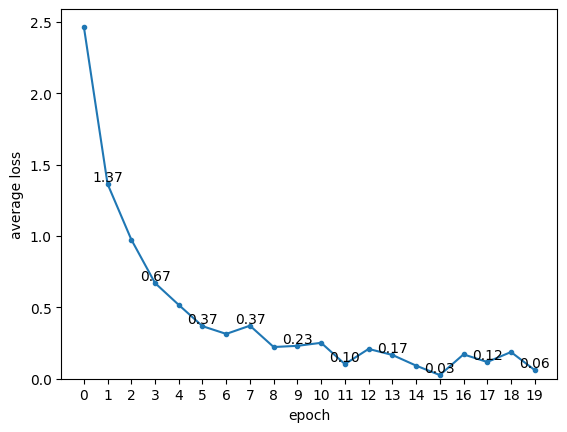

In [16]:
y_avg = []
for y in epochs_y:
    y_avg.append(np.mean(y))

plt.plot(np.arange(len(epochs_x)), y_avg, marker = '.')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.ylim(0,)
plt.xticks(np.arange(len(epochs_x)))
for i, txt in enumerate(y_avg):
    if i%2 == 0:
        pass
    else:
        plt.text(i, txt, f'{txt:.2f}', ha='center', va='bottom', color = 'k')
plt.show()

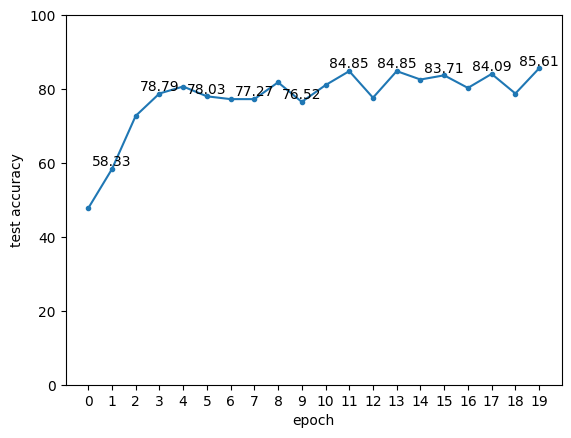

In [17]:
plt.plot(np.arange(len(epochs_x)), epochs_acc, marker = '.')
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.ylim(0, 100)
plt.xticks(np.arange(len(epochs_x)))
for i, txt in enumerate(epochs_acc):
    if i%2 == 0:
        pass
    else:
        plt.text(i, txt, f'{txt:.2f}', ha='center', va='bottom', color = 'k')
plt.show()